In [94]:
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)


(105,)

In [110]:
fn = 'Interspeech2021_Condition_1.csv'
# fn = 'Interspeech2021_Condition_2.csv'
df = pd.read_csv(fn)

print(fn)
print(df['subject'].unique().shape)

map_model_names = {
    'BASELINE_WAVENET_snrN20P10': 'wavenet_waveform',
    'BASELINE_IDENTITY': 'unprocessed_input',
    'BASELINE_GERMAIN_PRETRAINED': 'pretrained_germain',
    'BRAIN_012_LAYERS______rand_TASK______UNET_snrN20P10': 'unet_R123',
    'BRAIN_012_LAYERS______word_TASK______UNET_snrN20P10_BRAIN_snrInf': 'unet_W123',
    'BRAIN_012_LAYERS_audi______TASK______UNET_snrN20P10_BRAIN_snrInf': 'unet_A123',
    'BRAIN_012_LAYERS_audi_word_TASK______UNET_snrN20P10_BRAIN_snrInf': 'unet_A123W123',
    'BRAIN_0___LAYERS______rand_TASK______UNET_snrN20P10': 'unet_R1',
    'BRAIN_0___LAYERS______word_TASK______UNET_snrN20P10_BRAIN_snrInf': 'unet_W1',
    'BRAIN_0___LAYERS_audi______TASK______UNET_snrN20P10_BRAIN_snrInf': 'unet_A1',
    'BRAIN_0___LAYERS_audi_word_TASK______UNET_snrN20P10_BRAIN_snrInf': 'unet_A1W1',
    'BRAIN_____LAYERS_wave______TASK______UNET_snrN20P10': 'unet_waveform',
    'BRAIN_____LAYERS_coch______TASK______UNET_snrN20P10': 'unet_cochlear_human',
    'germain_dcase_unet_snrN20P10_cleanspeechl1layers': 'unet_germain_deep_features',
    'BRAIN_0___LAYERS______word_TASK_word_UNET_snrN20P10_BRAIN_snrInf': 'unet_W1T1',
    'brainless_unet_snrN20P10_cleanspeechl1RSB_sr10000_lp00100': 'unet_cochlear_envelopes',
    
    'brainless_unet_snrN20P10_subbands_erb_n005': 'unet_cochlear_human_n05',
    'brainless_unet_snrN20P10_subbands_erb_n010': 'unet_cochlear_human_n10',
    'brainless_unet_snrN20P10_subbands_erb_n020': 'unet_cochlear_human_n20',
    'brainless_unet_snrN20P10_subbands_erb_n080': 'unet_cochlear_human_n80',
    'brainless_unet_snrN20P10_subbands_erb_r': 'unet_cochlear_reverse',
    'brainless_unet_snrN20P10_subbands_linear':'unet_cochlear_linear',
}

map_column_names = {
    'sound_idx': 'sound_index',
    'subject': 'subject_index',
    'SNR': 'snr',
    'Naturalness Rating': 'naturalness',
    'Sound Name': 'sound_filename',
    'Foreground': 'sound_foreground',
    'Background Condition': 'sound_background',
    'Model Name': 'model',
}

df_new = df.copy()
df_new = df_new.replace({'Model Name': map_model_names})
df_new = df_new.drop(columns='Model')
df_new = df_new.rename(columns=map_column_names)
df_new['sound_index'] = df_new['sound_index'].astype(int)
df_new['subject_index'] = df_new['subject_index'].astype(int)
df_new['naturalness'] = df_new['naturalness'].astype(int)
# df_new['model'].unique()

# df_new.to_csv(fn.replace('Condition', 'experiment'))


Interspeech2021_Condition_1.csv
(54,)


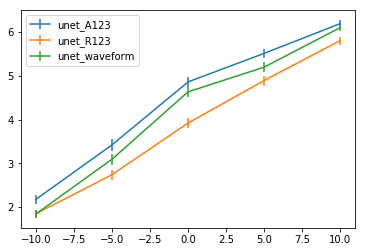

In [111]:
df_tmp = df_new.groupby(['model', 'snr']).agg({"naturalness": ["count", "mean", "sem"]}).reset_index()

list_model = [
#     'unet_A1',
    'unet_A123',
#     'unet_A123W123',
#     'unet_A1W1',
#     'unet_cochlear_human',
#     'unet_cochlear_reverse',
#     'unet_germain_deep_features',
#     'unet_R1',
    'unet_R123',
#     'unet_W1',
#     'unet_W123',
    'unet_waveform',
]

fig, ax = plt.subplots()

for model in list_model:
    df_tmp_tmp = df_tmp[df_tmp['model'] == model]
    
    x = df_tmp_tmp['snr'].values
    y = df_tmp_tmp['naturalness']['mean'].values
    yerr = df_tmp_tmp['naturalness']['sem'].values
    
    ax.errorbar(x, y, yerr=yerr, label=model)

ax.legend()
plt.show()
